In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel(r'../data/Datos Codificados Estudio v2a.xlsx')

<BarContainer object of 28 artists>

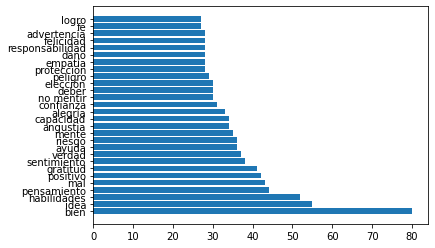

In [34]:
cod = data['Codificación'].value_counts()
reduce_cod = cod[cod>25]

names = list(reduce_cod.keys())
values = list(reduce_cod)

plt.barh(names, values)

In [42]:
print("Cantidad de codificaciones existente", cod.shape[0])

Cantidad de codificaciones existente 1296


In [41]:
print("Porcentaje de datos que solo tienen una codificación:",np.sum(cod == 1)/cod.shape[0])

Porcentaje de datos que solo tienen una codificación: 0.5169753086419753


¿Afecta esto en los resultados que se pueden obtener?
¿Podria intentar identificarlos?
